## Walkthrough notebook for the Empirical Trace Construction Module
Construct uncontaminated trace profiles for the first and second SOSS orders.

In [1]:
from astropy.io import fits
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sys import path
soss_path = '/Users/michaelradica/Documents/GitHub/jwst-mtl/'
path.insert(1, soss_path)

from SOSS.dms.soss_centroids import get_soss_centroids
from SOSS.extract.empirical_trace.construct_trace import replace_badpix
from SOSS.extract.empirical_trace.empirical_trace import EmpiricalTrace

/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/michaelradica/.anaconda3/envs/soss/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-036
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


Use a CV3 CLEAR and F277W deep stack as a test case.

In [23]:
# Open CV3 clear and F277W exposures.
filepath = '/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Input_Files/'
clear = fits.open(filepath+'cv3_clear.fits')[0].data[::-1]
f277w = fits.open(filepath+'cv3_f277.fits')[0].data[::-1, ::-1].T

# Replace reference pixel columns
for i in range(4):
    f277w[:, i] = f277w[:, 4]
    clear[:, i] = clear[:, 4]
    clear[:, 2044+i] = clear[:, 2043]

# Preform a rough background subtraction.
clear -= np.nanpercentile(clear, 1, axis=0)
f277w -= np.nanpercentile(f277w, 1, axis=0)

# Replace bad pixels.
clearr = replace_badpix(clear, np.isnan(clear))
ff277w = replace_badpix(f277w, np.isnan(clear))

In [24]:
# Get the trace centroids for all three orders.
cen = get_soss_centroids(clearr, subarray='SUBSTRIP256')

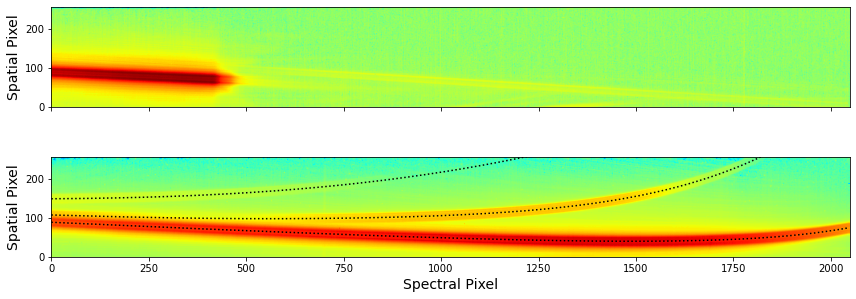

In [25]:
# Visualize the data frames.
f, ax = plt.subplots(2, sharex=True, figsize=(12, 5))
ax[0].imshow(np.log10(ff277w), origin='lower', cmap='jet')
ax[0].set_ylabel('Spatial Pixel', fontsize=14)

ax[1].imshow(np.log10(clearr), origin='lower', cmap='jet')
ax[1].plot(cen['order 1']['X centroid'], cen['order 1']['Y centroid'], ls=':', c='black')
ax[1].plot(cen['order 2']['X centroid'], cen['order 2']['Y centroid'], ls=':', c='black')
ax[1].plot(cen['order 3']['X centroid'], cen['order 3']['Y centroid'], ls=':', c='black')
ax[1].set_xlabel('Spectral Pixel', fontsize=14)
ax[1].set_ylabel('Spatial Pixel', fontsize=14)

plt.xlim(0, 2048)
plt.ylim(0, 256)

f.tight_layout()

The Empirical Trace Contruction module is accessed through the ```EmpiricalTrace``` class. Specifically, via calling its ```build_empirical_trace``` method after initalization. The two required arguments for the ```EmpiricalTrace``` class are a GR700XD/CLEAR exposure, as well as a bad pixel mask (first and third arguments respectively). 

It is recommended to include an exposure with the F277W filter in all NIRISS/SOSS observing programs, as this allows for a more accurate trace reconstruction in the region where the first two diffraction orders overlap. An F277W exposure can be passed to ```EmpiricalTrace``` as the second argument. If no F277W exposure is available, pass ```None``` in its place.

```EmpiricalTrace``` takes two optional arguments which control additional processing which can be done after the uncontaminated profiles are produced.
 - ```pad```: tuple, default (0, 0). Amount of padding to include (in native pixels) in the spatial and spectral directions, respectively.
 - ```oversample```: int, default 1. Oversampling factor. Oversampling will be equal in the spectral and spatial directions.
 
Additionally, the optional argument ```verbose```, governs the level of verbosity. There are 4 verbose levels available: 
 0. Silent (default).
 1. Show progress prints.
 2. Show both progress prints and bars.
 3. Show all of progress prints, progress bars, and diagnostic plots.
 
Two additional optional arguments can be passed to ```build_empirical_trace``` when calling the method:
 - ```normalize```: bool, default True. Whether to column normalize the final spatial profiles such that the flux in each column sums to one.
 - ```max_iter``` : int, default 1. The number of refinement iterations to perform on the spatial profiles. It is not recommended to set this argument to zero and not iterate. This will lead to highly inaccurate spatial profiles. 

In [26]:
# Initalize an EmpiricalTrace instance for a SUBSTRIP256 dataset with an F277W exposure.
bad_pix = np.isnan(clear)
etrace = EmpiricalTrace(clear, f277w, bad_pix, verbose=1)

In [27]:
# Run the empirical trace construction.
# Do not normalize in order to make direct comparisons with the original CLEAR dataframe.
etrace.build_empirical_trace(normalize=False)

Starting the Empirical Trace Construction module.

 Initial processing...
  Replacing bad pixels...
  Getting trace centroids...
 
Constructing first pass trace models...
  Starting the first order trace model...
   Calibrating trace widths...
   Getting anchor profiles...
   Interpolating trace...
   Stitching data and reconstructing wings...
   Rescaling first order to native flux level...
  Building the second order trace model...
   Reconstructing oversubtracted wings...
   Dealing with oversubtracted cores...
   Smoothing...
 First pass models complete.
 
Starting spatial profile refinement...
 iteration 1/1
  Refining the first order...
  Refining the second order...
   Reconstructing oversubtracted wings...
   Smoothing...
 Adding padding to the spectral axis...

Done.


To save the trace profiles to a file, use the ```save_to_file``` method. This method accepts the optional ```filename``` argument to specify the file to which the profiles will be written. If no filename is provided, it will default to 'SOSS_2D_profile_{subarray}.fits'.

Regardless of whether the uncontaminated trace profiles are written to a file, they are stored as attributes to the ```EmpiricalTrace``` object and can be accessed via the ```order1``` and ```order2``` attributes respectively. 

In [ ]:
etrace.save_to_file()

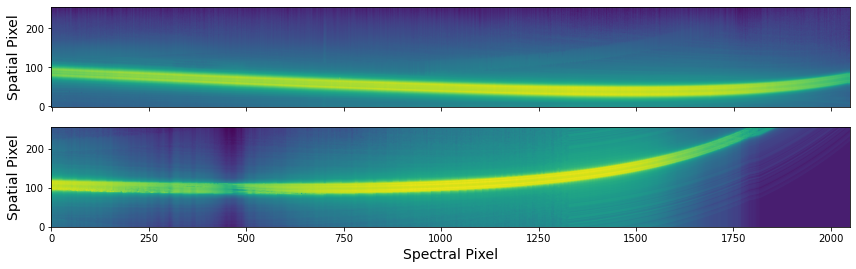

In [7]:
# Visualize the reonconstructed data frames
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax1 = plt.subplot(gs[0])
ax1.imshow(np.log10(etrace.order1), origin='lower')
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax2 = plt.subplot(gs[1])
ax2.imshow(np.log10(etrace.order2), origin='lower')
ax2.set_xlabel('Spectral Pixel', fontsize=14)
ax2.set_ylabel('Spatial Pixel', fontsize=14)
ax2.set_xlim(0, 2048)
ax2.set_ylim(0, 256)

fig.tight_layout()

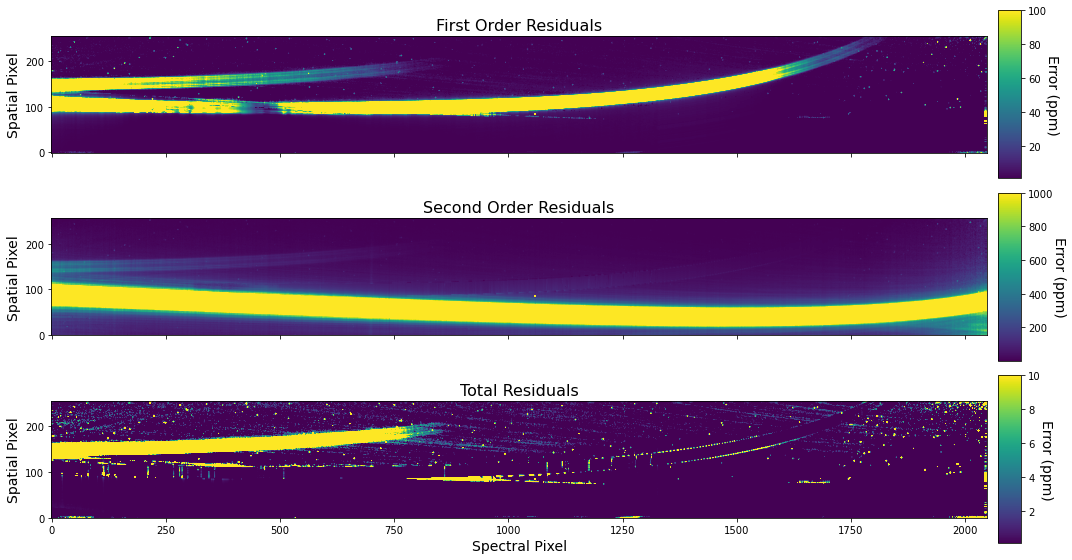

In [8]:
# Compare the reconstructed profiles to the original data.
# Residuals are shown as a fraction of the total column flux.
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 0.025])

ax1 = plt.subplot(gs[0, 0])
im1 = ax1.imshow((clearr - (etrace.order1))/np.nansum(clearr, axis=0)*1e6, origin='lower',
                 vmin=1, vmax=1e2)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.set_ylabel('Spatial Pixel', fontsize=14)
ax1.set_title('First Order Residuals', fontsize=16)

ax2 = plt.subplot(gs[0, 1])
cb = Colorbar(ax=ax2, mappable=im1, orientation='vertical', ticklocation='right')
cb.set_label(r'Error (ppm)', labelpad=12, rotation=270, fontsize=14)

ax3 = plt.subplot(gs[1, 0])
im2 = ax3.imshow((clearr - (etrace.order2))/np.nansum(clearr, axis=0)*1e6, origin='lower',
                 vmin=1, vmax=1e3)
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_ylabel('Spatial Pixel', fontsize=14)
ax3.set_title('Second Order Residuals', fontsize=16)

ax4 = plt.subplot(gs[1, 1])
cb = Colorbar(ax=ax4, mappable=im2, orientation='vertical', ticklocation='right')
cb.set_label(r'Error (ppm)', labelpad=12, rotation=270, fontsize=14)

ax5 = plt.subplot(gs[2, 0])
im3 = ax5.imshow((clearr - (etrace.order1+etrace.order2))/np.nansum(clearr, axis=0)*1e6,
                 origin='lower', vmin=0.1, vmax=10)
ax5.set_xlabel('Spectral Pixel', fontsize=14)
ax5.set_ylabel('Spatial Pixel', fontsize=14)
ax5.set_title('Total Residuals', fontsize=16)

ax6 = plt.subplot(gs[2, 1])
cb = Colorbar(ax=ax6, mappable=im3, orientation='vertical', ticklocation='right')
cb.set_label(r'Error (ppm)', labelpad=12, rotation=270, fontsize=14)

fig.tight_layout()

In each case, the appropriate order is well subtracted, and residuals (outside of the third order) are generally <10ppm of total column flux. 

Subarrays 'FULL' and 'SUBSTRIP96' are also supported. However, in the case of SUBSTRIP96, only a first order profile is able be produced. It is then recommended to use a reference file and the simple solver in order to obtain a 2D profile for the second order. 